In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geopandas.org/_images/overlay_operations.png")

# Spatial Join on CPU and GPU  - Standard function

In [2]:
import time
import geopandas as gpd
from numba.extending import overload
import matplotlib.pyplot as plt

# data_1 - point, data_2 = polygon
def sjoin_without_indexing(data_1, data_2, device = 'CPU', plot = False):
    start_time = time.time()
    join_result = gpd.sjoin(data_1, data_2, how="inner", op='intersects')
    end_time = time.time()
    
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))
    
#     plotting the sjoin results 
    if plot:
        
        f, ax = plt.subplots(figsize=(10, 10))

        data_1.plot(ax = ax, marker = 'o', color = 'blue', markersize = 5)
        data_2.plot(ax = ax, color = 'grey')
        join_result.plot(ax = ax, marker = 'o', color = 'red', markersize = 5)

        plt.show()    
    
    return join_result

@overload(sjoin_without_indexing)
def gpu_sjoin_without_indexing(data1, data2, plot = True):
    return sjoin_without_indexing(data1, data2, device = 'GPU', plot = plot)

S-join without splitting on GPU = 3.4126763343811035


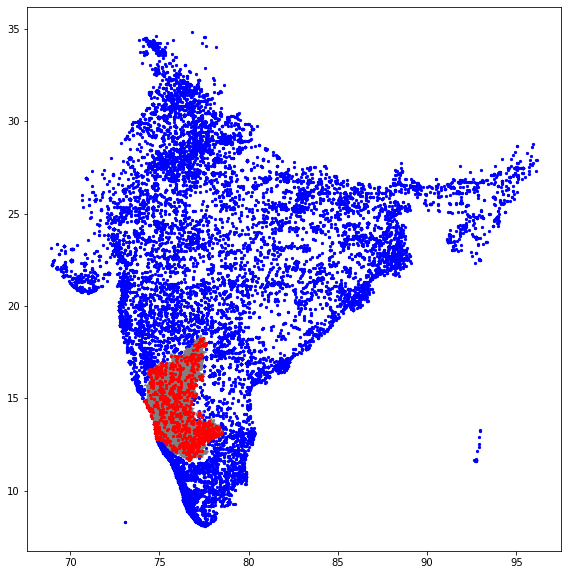

Number of points in result: 2714


In [3]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import osmnx as ox

data_1 = gpd.read_file("Datasets/India_hospitals/india_hospitals_point.shp")  # Points
data_2 = ox.geocode_to_gdf('Karnataka, India') # Polygon

std_result = gpu_sjoin_without_indexing(data_1, data_2, plot = True)
print("Number of points in result:", len(std_result))

# Spatial Join on CPU and GPU - Brute force

In [ ]:
"""
Algorithm 1: Brute Force Spatial Join on GPU 
 Input: data_1: Point Dataset, data_2: Polygon Dataset
  Output: points_within_geometry: Points obtained after joining the datasets
  1:  geometry_2 ← Select all Points from column data_2[‘geometry’]
  2:  if geometry_2 is instance of Polygon then
  3:  	geometry_2 ← MultiPolygon(geometry_2)
  4:  	end if
  5:  points_within_geometry ← data_1[data_1 intersects geometry_2]
  6:  return points_within_geometry
"""

In [4]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload

import matplotlib.pyplot as plt
import time

def sjoin_brute_force(data_1, data_2, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_2 = data_2['geometry'].iloc[0]
    if isinstance(geometry_2, Polygon):
        geometry_2 = MultiPolygon([geometry_2])
    
#     brute force join
    start = time.time()
    precise_matches = data_1[data_1.intersects(geometry_2)]    
    end = time.time()
    total_time = end-start
    print('Total time:', total_time)
    
    points_within_geometry = precise_matches
    points_outside_geometry = data_1[~data_1.isin(points_within_geometry)]
    
    print("Brute force S-join on {0} = {1}".format(device, total_time))
    
#     plotting the sjoin results 
    if plot:
        
        f, ax = plt.subplots(figsize=(10, 10))

        data_1.plot(ax = ax, marker = 'o', color = 'blue', markersize = 5)
        data_2.plot(ax = ax, color = 'grey')
        points_within_geometry.plot(ax = ax, marker = 'o', color = 'red', markersize = 5)

        plt.show()    
    
    return points_within_geometry
    
@overload(sjoin_brute_force)
def gpu_sjoin_brute_force(data_1, data_2, device = 'CPU', plot = True):
    return sjoin_brute_force(data_1, data_2, device = 'GPU', plot = plot)    

Total time: 23.65958571434021
Brute force S-join on GPU = 23.65958571434021


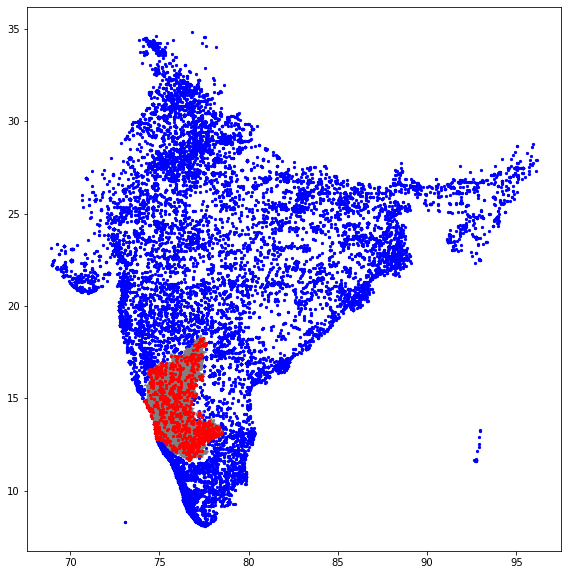

Number of points in result: 2714


In [5]:
import osmnx as ox

data_1 = gpd.read_file("Datasets/India_hospitals/india_hospitals_point.shp")  # Points
data_2 = ox.geocode_to_gdf('Karnataka, India') # Polygon

brute_result = gpu_sjoin_brute_force(data_1, data_2, plot = True)
print("Number of points in result:", len(brute_result))

# Spatial Join on CPU and GPU with indexing and without splitting

In [ ]:
"""
  Algorithm: Spatial Join with Indexing
  Input: data_1: Point Dataset, data_2: Polygon Dataset
  Output: points_within_geometry: Points obtained after joining the datasets
  1:  geometry_2 ← Select all data Points column data_2[‘geometry’]
  2:  if geometry_2 is instance of Polygon then
  3:	  geometry_2 ← MultiPolygon(geometry_2)
  4:  	  end if
  5:  sindex_1 ← Spatial Index data_1
  6:  let possible_indices = array holding coordinates of intersection of the datasets
  7:  for each sindex in sindex_1:
  8:  	  add sindex intersects MBR(geometry_2) to possible_indices
  9:	  end for
 10:  possible_matches ← Select all Points from column data_1[possible_indices]
 11:  points_within_geometry ← possible_matches[possible_matches intersects geometry_2]
 12:  return points_within_geometry
"""

In [6]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload

import matplotlib.pyplot as plt
import time

def sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_2 = data_2['geometry'].iloc[0]
    if isinstance(geometry_2, Polygon):
        geometry_2 = MultiPolygon([geometry_2])
        
    start = time.time()
#     indexing data_2 - point dataset
    sindex_1 = data_1.sindex
    
    end = time.time()
    sindex_time = end - start
    print('Time taken to index point dataset:', sindex_time)
    
#     filter phase
    start = time.time()
    possible_indices = list(sindex_1.intersection(geometry_2.bounds))
    end = time.time()
    possible_matches = data_1.iloc[possible_indices]
    filter_time = end-start
    print('Filter time:', filter_time)
    print("Number of reduced points after filtering:", len(possible_matches))
    
#     refinement phase
    start = time.time()
    # cannot use index structure of data 2 for intersects operation, accepts Series datatype only   
    precise_matches = possible_matches[possible_matches.intersects(geometry_2)]  
    end = time.time()
    refinement_time = end-start
    print('Refinement time:', refinement_time)
    
#     plotting the sjoin results 
    points_within_geometry = precise_matches
    points_outside_geometry = data_1[~data_1.isin(points_within_geometry)]
    
    print("S-join with indexing and without splitting on {0} = {1}".format(device, sindex_time + refinement_time + filter_time))
    
    if plot:
        
        f, ax = plt.subplots(figsize=(10, 10))

        data_1.plot(ax = ax, marker = 'o', color = 'blue', markersize = 5)
        data_2.plot(ax = ax, color = 'grey')
        points_within_geometry.plot(ax = ax, marker = 'o', color = 'red', markersize = 5)

        plt.show()    
    
    return points_within_geometry
    
@overload(sjoin_with_indexing)
def gpu_sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    return sjoin_with_indexing(data_1, data_2, device = 'GPU', plot = plot)    

Time taken to index point dataset: 1.2276701927185059
Filter time: 0.0040531158447265625
Number of reduced points after filtering: 5698
Refinement time: 23.611151456832886
S-join with indexing and without splitting on GPU = 24.842874765396118


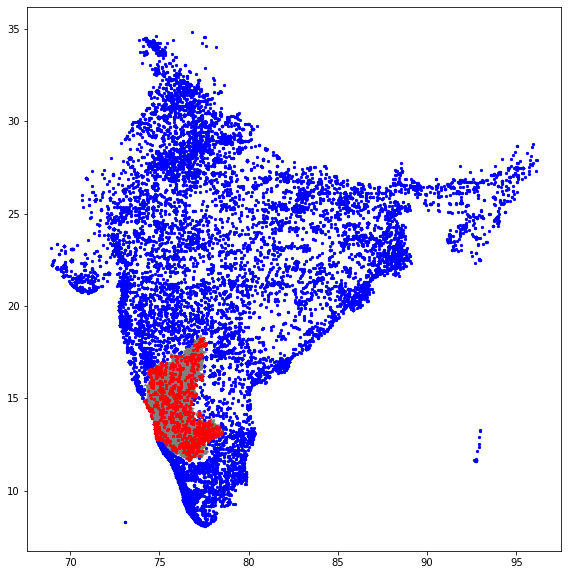

Number of points in result: 2714


In [7]:
import osmnx as ox

data_1 = gpd.read_file("Datasets/India_hospitals/india_hospitals_point.shp")  # Points
data_2 = ox.geocode_to_gdf('Karnataka, India') # Polygon

index_result = gpu_sjoin_with_indexing(data_1, data_2, plot = True)
print("Number of points in result:", len(index_result))

# Spatial Join on CPU and GPU with indexing and splitting

In [ ]:
"""
  Algorithm: Spatial Join with Indexing & Splitting
  Input: data_1: Point Dataset, data_2: Polygon Dataset, quad_width: Sub-partition grid size 
  Output: points_within_geometry: Points obtained after joining the datasets
  1:  geometry_2 ← Select all data Points column data_2[‘geometry’]
  2:  if geometry_2 is instance of Polygon then
  3:	  geometry_2 ← MultiPolygon(geometry_2)
  4:  	  end if
  5:  sindex_1 ← Spatial Index data_1
  6:  geometry_cut ← Split data_2 into grids of size quad_width
  7:  let points_within_geometry = array holding coordinates of intersection o the datasets
  8:  for each grid in geometry_cut:  	  
  9:  	  let possible_indices = array holding filtered coordinates of intersection of the datasets
 10:         for each sindex in sindex_1:
 11:  	  	add sindex intersects MBR(grid) to possible_indices
 12:	 	end for
 13:  	  possible_matches ← Select all Points from column data_1[possible_indices]
 14:         precise_matches ← possible_matches[possible_matches intersects geometry_2]
 15:	  add precise_matches to points_within_geometry
 16:  	  end for
 17:  return points_within_geometry
"""

In [8]:
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload
from numba import jit

import matplotlib.pyplot as plt
import time

import osmnx as ox

def sjoin_with_splitting(data_1, data_2, device = 'CPU',split_size = 0.75, plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_2 = data_2['geometry'].iloc[0]
    if isinstance(geometry_2, Polygon):
        geometry_2 = MultiPolygon([geometry_2])
          
#     indexing data_2
    start = time.time()  
    sindex_1 = data_1.sindex
    end = time.time()
    
    sindex_time = end-start
    print('Time taken to index points: ', sindex_time)

    points_within_geometry = pd.DataFrame()
    filter_time = 0
    refinement_time = 0

#     Splitting polygon data into squares
    start = time.time()
    geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry_2, quadrat_width = split_size)
    end = time.time()
    filter_time += (end-start)
    print('Time taken for sub-partitioning: ', filter_time)
    
    filter_points = 0
    
    for sub_poly in geometry_cut:  
        
        # filter phase 
        start = time.time()
        sub_poly = sub_poly.buffer(1e-14).buffer(0)
        possible_indices = list(sindex_1.intersection(sub_poly.bounds))
        possible_matches = data_1.iloc[possible_indices]
        end = time.time()
        filter_time += (end-start)
        filter_points += len(possible_matches)

        # refinement phase
        start = time.time()
        precise_matches = possible_matches[possible_matches.intersects(sub_poly)]
        points_within_geometry = points_within_geometry.append(precise_matches)
        end = time.time()
        refinement_time += (end-start)
    
    print('Number of splits: ', len(geometry_cut))
    print("Number of reduced points after filtering:", filter_points)
    print('Filter time:', filter_time)
    print('Refinement time:', refinement_time)
    print("S-join with splitting on {0} = {1}".format(device, sindex_time + filter_time +  refinement_time)) 

    # plotting the sjoin results      
    if plot:        
        f, ax = plt.subplots(figsize=(10, 10))
        
        data_1.plot(ax = ax, marker = 'o', color = 'blue', markersize = 5)
        data_2.plot(ax = ax, color = 'grey')
        points_within_geometry.plot(ax = ax, marker = 'o', color = 'red', markersize = 5)

        plt.show()
    
    return points_within_geometry
#     return geometry_cut
    
@overload(sjoin_with_splitting)
def gpu_sjoin_with_splitting(data_1, data_2, device = 'GPU',split_size = 0.75, plot = True):
    return sjoin_with_splitting(data_1, data_2, device, split_size, plot)

Time taken to index points:  1.2452504634857178
Time taken for sub-partitioning:  4.495103359222412
Number of splits:  584
Number of reduced points after filtering: 2742
Filter time: 5.399974584579468
Refinement time: 1.4696414470672607
S-join with splitting on GPU = 8.114866495132446


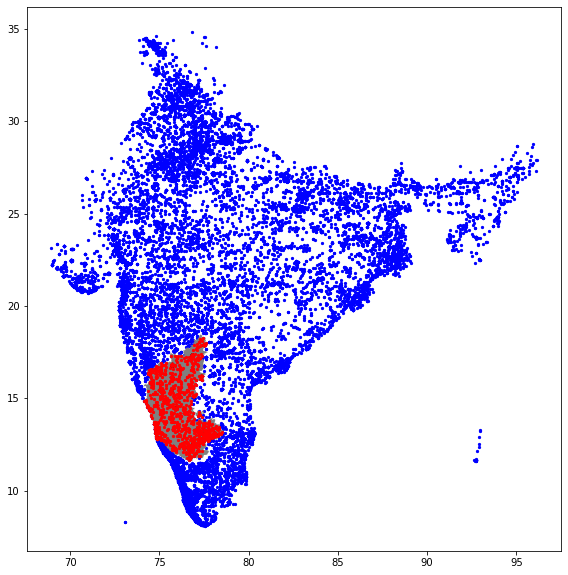

Number of points in result: 2714


In [9]:
import osmnx as ox

data_1 = gpd.read_file("Datasets/India_hospitals/india_hospitals_point.shp")  # Points
data_2 = ox.geocode_to_gdf('Karnataka, India') # Polygon

split_result_1 = gpu_sjoin_with_splitting(data_1, data_2, split_size = 0.2, plot = True)
print("Number of points in result:", len(split_result_1))

Time taken to index points:  1.2401206493377686
Time taken for sub-partitioning:  0.881223201751709
Number of splits:  100
Number of reduced points after filtering: 3034
Filter time: 1.2580876350402832
Refinement time: 0.6325881481170654
S-join with splitting on GPU = 3.130796432495117


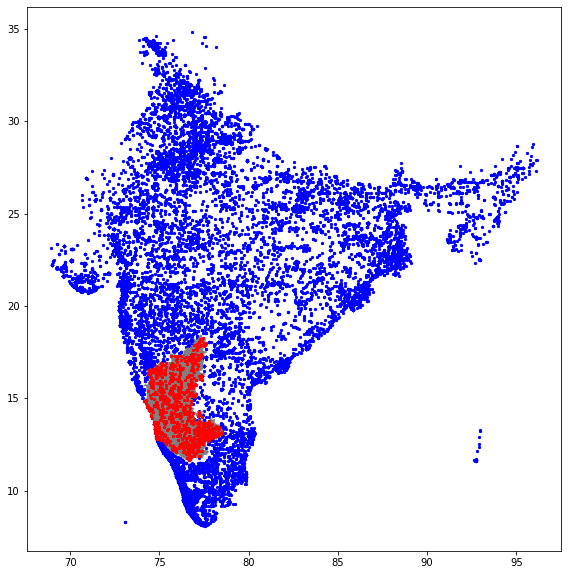

Number of points in result: 2714


In [10]:
import osmnx as ox

data_1 = gpd.read_file("Datasets/India_hospitals/india_hospitals_point.shp")  # Points
data_2 = ox.geocode_to_gdf('Karnataka, India') # Polygon

split_result_2 = gpu_sjoin_with_splitting(data_1, data_2, split_size = 0.75, plot = True)
print("Number of points in result:", len(split_result_2))